## Workflow to generate ensemble parameter combinations

This is specifically for the cultivar file

In [3]:
# this loads previoulsy stored environment
import dill
dill.load_session('opt_param_env.db')

In [37]:
# Load in necessary packages
import os
import pandas as pd
import numpy as np
import glob as glob
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from pyDOE import *

# personal functions
from funcs import unfold, tup_convert

### 1. Create dataframe with all parameters

* phenology
    - staygreen *
    - juv_leaves *
    - maxElongRate: max elongation rate at optimal temperature (12 cm/day)
    - rmax_lir: max leaf initation rate (leaves/day) *
    - rmax_ltar: max leaf tip appearance rate (leaves/day) *
* morphology
    - LAF: leaf angle factor for corn leaves (1.37)
    - f: spectral correction (0.15) *
    - scatt: leaf reflectance and transmittance (0.15) *
    - leaf_wid: leaf width (0.05 m) *
    - WLRARIO: leaf width to length ratio (0.106)
    - A_LW: leaf area coefficient with respect to LxW (0.75)
* physiology
    - vcm25: *
    - vpm25: *
    - g0: *
    - g1: *
    - t_opt: 
* water stress
    - psi_threshold: 

In [5]:
# genetic parameter list
params = ['staygreen', 'rmax_lir', 'rmax_ltar', 'juv_leaves', # phenology
          'leaf_wid', 'WLRATIO', 'A_LW', 'LAF', 'f', 'scatt', # morphology
          'vcm_25', 'vpm_25', 'g0', 'g1', 't_opt', # physiology
          'psi_threshold'] # water stress

#### ensemble paramter range

In [57]:
# 200228: range of these parameters still need to be checked/updated
param_range = {'staygreen':[1,6],
               'rmax_lir': [0.1, 0.5],
               'rmax_ltar': [0.1, 1.5],
               'juv_leaves': [12, 20],
               'leaf_wid': [0.02, 0.08],
               'WLRATIO': [1, 2],
               'A_LW': [0.5, 1],
               'LAF': [1, 3],
               'f': [0, 1],
               'scatt': [0, 1],
               'vcm_25': [40, 60],
               'vpm_25': [60, 80],
               'g0': [0.02, 0.1], # can check the range of these values from literature maybe?
               'g1': [2, 4],      # ball-berry slope & intercept
               't_opt': [20, 28],
               'psi_threshold': [-5, -1]}

### 2. Use Latin hypercube to find parameter combinations

info on this method here: https://pythonhosted.org/pyDOE/randomized.html

In [58]:
sample = lhs(len(params), samples=5) # trying with 5 cultivar combinations for now
df_params = pd.DataFrame(sample, columns=params)

for i in params: 
    df_params[i] = unfold(df_params[i], param_range[i][0], param_range[i][1])

# constraining leaf number to be integers only
df_params.juv_leaves = [round(x) for x in df_params.juv_leaves]
df_params.head()

,staygreen,rmax_lir,rmax_ltar,juv_leaves,leaf_wid,WLRATIO,A_LW,LAF,f,scatt,vcm_25,vpm_25,g0,g1,t_opt,psi_threshold
0,4.627706,0.177132,1.237111,16,0.055335,1.175000,0.782406,1.194800,0.431257,0.496593,51.550546,63.039504,0.034482,2.620581,27.273348,-4.956807
1,5.808591,0.351544,0.521350,19,0.075660,1.511410,0.512995,1.705362,0.009592,0.066470,58.037710,70.057775,0.047734,3.883682,20.531351,-1.826928
2,2.127455,0.491746,0.841061,17,0.027573,1.646500,0.964020,2.454793,0.302035,0.803085,54.684174,77.673592,0.098986,3.126550,23.555950,-1.467304
3,3.349920,0.201402,1.164075,14,0.060892,1.222617,0.882206,1.867997,0.739832,0.272847,46.142843,64.763926,0.078657,2.009876,22.705069,-3.945179
4,1.163566,0.325390,0.238049,13,0.036555,1.830852,0.672305,2.653484,0.859201,0.653647,41.136666,74.172086,0.053623,3.551193,25.304715,-2.777699


Visualizing parameter spread:

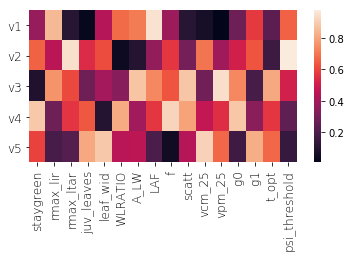

In [82]:
sample = lhs(len(params), samples=5) # trying with 5 cultivar combinations for now
df_test = pd.DataFrame(sample, columns=params)
df_test.index = ['v1','v2','v3','v4','v5']

fig, ax = plt.subplots()
ax = sns.heatmap(df_test)
plt.xticks(
    fontweight='light',
    fontsize='large')
plt.yticks(
    rotation=0,
    fontweight='light',
    fontsize='large')
fig.subplots_adjust(bottom=0.35)

plt.savefig('/home/disk/eos8/ach315/upscale/figs/params.png', format='png', dpi=1200)

### 3. Setting up planting dates

In [14]:
# planting date range
season_start = datetime.datetime(1990,3,1)
season_end = datetime.datetime(1990,5,31)
dates = np.arange(season_start, season_end, datetime.timedelta(3))

pdates = []
for i in dates:
    pdates.append((str(i)[4:10]))

### 4. Creating cultivar init file template

#### constant parameters:

In [59]:
# cultivar traits
(gdd_mature, daylen_sen, LA_min, phyllo) = (1600, 0, 100, 3)

# soil water
(rrrm, rrry, rvrl) = (166.7, 31.3, 0.73)
(alpm, alpy, rtwl, rtminwtperunitarea) = (0.35, 0.04, 1.059e-004, 2.0000e-004)
(epsi, lupw, courmax) = (1, 1, 1)
(diffgeo1, diffgeo2, diffgoe3) = (2.4, 2.9, 0)
(wl, wa, wr, wb) = (1, 1, 2, 10)

# soil nitrogen
(isink, rroot) = (0, 0.017)
(consti_1, constk_1, cmin0_1) = (35.0, 0.5, 0.01)
(consti_2, constk_2, cmin0_2) = (17.2, 0.75, 0.30)

# photosynthesis
(eavp, eavc, eaj, hj, sj, jm_25, rd_25, ear) = (75100, 55900, 32800, 220000, 702.6, 300, 2, 39800)
(Kc_25, Ko_25, Kp_25, gbs, gi, gamma1) = (650, 450, 80, 0.003, 1, 0.193)
(gamma_gsw, sf, ref_potential, stoma_ratio, widfct) = (10.0, 2.3, -1.2, 1.0, 0.72)
(cica_ratio, SC_param, BLC_param) = (0.7, 1.57, 1.36)

In [28]:
# setting up strings
def strings(): 
    tab = '    '
    str1 = '*** Corn growth simulation for US maize simualtion\n'
    str2 = 'cultivar: Romario\n'
    str3 = ('gdd_mature' + tab + 'juv_leaf' + tab + 'daylen_sen' + tab + 'staygreen' + tab + 
            'LA_min' + tab + 'Rmax_LTAR' + tab + 'Rmax_LTIR' + tab + 'phyllo\n')
    str4 = '\n'
    str5 = tup_convert(['%.0f' %gdd_mature, tab, '%.0f' %juv_leaves, tab, '%.0f' %daylen_sen, tab, 
                        '%.f' %staygreen, tab, '%.f' %LA_min, tab, 
                        '%.2f' %rmax_ltar, tab, '%.2f' %rmax_lir, tab, '%.0f\n' %phyllo])

    str6 = '[SoilRoot]\n'
    str7 = '*** water uptake parameter information ***\n'
    str8 = 'RRRM' + tab + 'RRRY' + tab + 'RVRL\n'
    str9 = tup_convert(['%.2f' %rrrm, tab, '%.2f' %rrry, tab, '%.2f\n' %rvrl])
    str10 = 'ALPM' + tab + 'ALPY' + tab + 'RTWL' + tab + 'RtMinWtPerUnitArea\n'
    str11 = tup_convert(['%.2f' %alpm, tab, '%.2f' %alpy, tab, '%.7f' %rtwl, tab, '%.4f\n' %rtminwtperunitarea])

    str12 = '[RootDiff]\n'
    str13 = '*** root mover parameter information\n'
    str14 = 'EPSI' + tab + 'lUpW' + tab + 'CourMax\n'
    str15 = tup_convert(['%.f' %epsi, tab, '%.f' %lupw, tab, '%.f\n' %courmax])
    str16 = 'Diffusivity and geotrophic velocity\n'
    str17 = tup_convert(['%.1f' %diffgeo1, tab, '%.1f' %diffgeo2, tab, '%.1f\n' %diffgoe3])

    str18 = '[SoilNitrogen]\n'
    str19 = '*** nitrogen root uptake parameter infromation ***\n'
    str20 = 'ISINK' + tab + 'Rroot\n'
    str21 = tup_convert(['%.0f' %isink, tab, '%.2f\n' %rroot])
    str22 = 'ConstI' + tab + 'Constk' + tab + 'Cmin0\n'
    str23 = tup_convert(['%.1f' %consti_1, tab, '%.1f' %constk_1, tab, '%.2f\n' %cmin0_1])
    str24 = tup_convert(['%.1f' %consti_2, tab, '%.2f' %constk_2, tab, '%.2f\n' %cmin0_2])

    str25 = '[Gas_Exchange Species Parameters]\n'
    str26 = '*** for photosynthesis calculations ***\n'
    str27 = ('EaVP' + tab + 'EaVc' + tab + 'Eaj' + tab + 'Hj' + tab + 'Sj' + tab + 'Vpm25' +
             tab + 'Vcm25' + tab + 'Jm25' + tab + 'Rd25' + tab + 'Ear' + tab + 'g0' + tab + 'g1\n')
    str28 = tup_convert(['%.f' %eavp, tab, '%.f' %eavc, tab, '%.f' %eaj, tab, '%.f' %hj, tab, '%.f' %sj, tab, 
                         '%.f' %vpm_25, tab, '%.f' %vcm_25, tab, '%.f' %jm_25, tab, '%.f' %rd_25, tab,
                         '%.f' %ear, tab, '%.2f' %g0, tab, '%.2f\n' %g1])

    str29 = '*** second set of parameters for photosynthesis ***\n'
    str30 = 'f' + tab + 'scatt' + tab + 'Kc_25' + tab + 'Ko_25' + tab + 'Kp_25' + tab + 'gbs' + tab + 'gi' + tab + 'gamma1\n'
    str31 = tup_convert(['%.2f' %f, tab, '%.2f' %scatt, tab, '%.2f' %Kc_25, tab, '%.2f' %Ko_25, tab, 
                         '%.2f' %Kp_25, tab, '%.3f' %gbs, tab, '%.2f' %gi, tab, '%.2f\n' %gamma1])
    
    str32 = '*** third set of photosynthesis parameters ***\n'
    str33 = ('gamma_gsw' + tab + 'sensitivity (sf)' + tab + 'ref_potential (phyla, bars)' + tab + 
            'stoma_ratio' + tab + 'widfct' + tab + 'leaf_wid (m)\n')
    str34 = tup_convert(['%.1f' %gamma_gsw, tab, '%.1f' %sf, tab, '%.1f' %ref_potential, tab, 
                       '%.1f' %stoma_ratio, tab, '%.1f' %widfct, tab, '%.3f\n' %leaf_wid])
    str35 = '**** seconday parameters for miscelanioius equations ****\n'
    str36 = 'Ci/Ca' + tab + 'SC_param' + tab + 'BLC_param\n'
    str37 = tup_convert(['%.1f' %cica_ratio, tab, '%.2f' %SC_param, tab, '%.2f\n' %BLC_param])
    str38 = '[Leaf Parameters]\n'

    # combining strings
    strs = [str1, str2, str3, str4, str5, str6, str7, str8, str9, str10, 
            str11, str12, str13, str14, str15, str16, str17, str18, str19, str20, 
            str21, str22, str23, str24, str25, str26, str27, str28, str29, str30, 
            str31, str32, str33, str34, str35, str36, str37, str38]
    
    return(strs)

In [29]:
strings()

['*** Corn growth simulation for US maize simualtion\n',
 'cultivar: Romario\n',
 'gdd_mature    juv_leaf    daylen_sen    staygreen    LA_min    Rmax_LTAR    Rmax_LTIR    phyllo\n',
 '\n',
 '1600    13    0    4    100    0.28    0.32    3\n',
 '[SoilRoot]\n',
 '*** water uptake parameter information ***\n',
 'RRRM    RRRY    RVRL\n',
 '166.70    31.30    0.73\n',
 'ALPM    ALPY    RTWL    RtMinWtPerUnitArea\n',
 '0.35    0.04    0.0001059    0.0002\n',
 '[RootDiff]\n',
 '*** root mover parameter information\n',
 'EPSI    lUpW    CourMax\n',
 '1    1    1\n',
 'Diffusivity and geotrophic velocity\n',
 '2.4    2.9    0.0\n',
 '[SoilNitrogen]\n',
 '*** nitrogen root uptake parameter infromation ***\n',
 'ISINK    Rroot\n',
 '0    0.02\n',
 'ConstI    Constk    Cmin0\n',
 '35.0    0.5    0.01\n',
 '17.2    0.75    0.30\n',
 '[Gas_Exchange Species Parameters]\n',
 '*** for photosynthesis calculations ***\n',
 'EaVP    EaVc    Eaj    Hj    Sj    Vpm25    Vcm25    Jm25    Rd25    Ear    g0 

#### parameter perturbation:

In [30]:
for i in np.arange(df_params.shape[0]):
    [staygreen, rmax_lir, rmax_ltar, juv_leaves, leaf_wid, WLRATIO, 
     A_LW, LAF, f, scatt, vcm_25, vpm_25, g0, g1, t_opt, psi_threshold] = df_params.iloc[i,:]
    strs = strings()
    var = open('/home/disk/eos8/ach315/upscale/inits/var/var_' + str(i) + '.txt', 'w')
    var.writelines(strs)
    var.close()

In [6]:
dill.dump_session('opt_param_env.db')